## Notebook showcasing the various options in Roodmus for analysis and visualisations
Each analysis functionality aims to compare output from a Single Particle Reconstruction workflow in RELION or CryoSPARC to the ground-truth information available from the generated Parakeet config files. The functions return a dictionary that can be converted to a pandas data frame for easy plotting and further analysis. This notebook allows the user as much flexibility as possible in creating their own analyses.

The provided tools include:
1. comparison of estimated and ground-truth CTF parameters
2. particle picking analysis

In [17]:
### imports
# general
import os
import mrcfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# roodmus
from roodmus.analysis.analyse_ctf import ctf_estimation
from roodmus.analysis.plot_ctf import plot_CTF, plot_defocus_scatter
from roodmus.analysis.analyse_picking import particle_picking
from roodmus.analysis.plot_picking import label_micrograph_picked, label_micrograph_truth, label_micrograph_truth_and_picked, plot_precision, plot_recall, plot_boundary_investigation, plot_overlap_investigation


### CTF estimation


In [2]:
### variables
config_dir = "data/6xm5_steered_Roodmus_1/mrc/"
meta_file = "data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs"

verbose = True

In [3]:
### analyse CTF estimation
analysis_ctf = ctf_estimation(meta_file, config_dir, verbose=verbose)
df_ctf = pd.DataFrame(analysis_ctf.results)
df_ctf

loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs...
found 358378 particles in 200 micrographs


loading ground-truth ctf parameters: 100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


ground-truth ctf values loaded. (358378, 5) ctf values found
estimated ctf values loaded. (358378, 6) ctf values found


,ugraph_filename,defocusU,defocusV,kV,Cs,amp,Bfac,defocus_truth,kV_truth,Cs_truth
0,000000.mrc,1544.884766,1544.884766,300.0,2.7,0.07,0.0,1459.348516,300.0,2.7
1,000000.mrc,1544.884766,1544.884766,300.0,2.7,0.07,0.0,1459.348516,300.0,2.7
2,000000.mrc,1544.884766,1544.884766,300.0,2.7,0.07,0.0,1459.348516,300.0,2.7
3,000000.mrc,1544.884766,1544.884766,300.0,2.7,0.07,0.0,1459.348516,300.0,2.7
4,000000.mrc,1544.884766,1544.884766,300.0,2.7,0.07,0.0,1459.348516,300.0,2.7
...,...,...,...,...,...,...,...,...,...,...
358373,000199.mrc,3030.407227,3030.407227,300.0,2.7,0.07,0.0,3073.016084,300.0,2.7
358374,000199.mrc,3030.407227,3030.407227,300.0,2.7,0.07,0.0,3073.016084,300.0,2.7
358375,000199.mrc,3030.407227,3030.407227,300.0,2.7,0.07,0.0,3073.016084,300.0,2.7
358376,000199.mrc,3030.407227,3030.407227,300.0,2.7,0.07,0.0,3073.016084,300.0,2.7


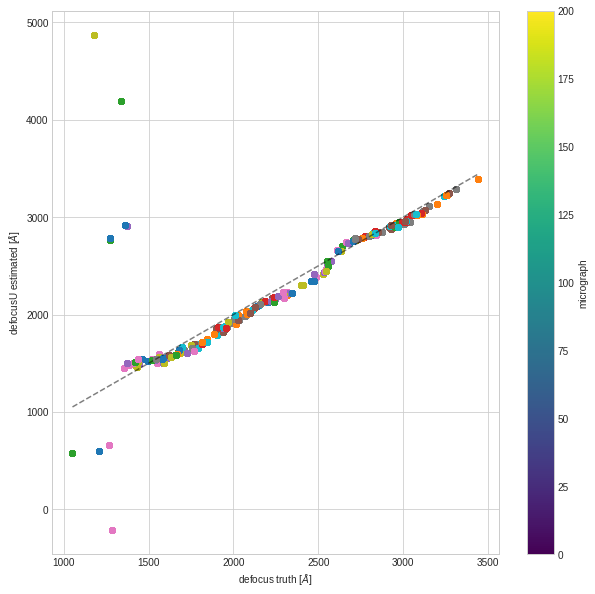

In [4]:
### scatter plot of the estimated vs. the true defocus values
fig, ax = plot_defocus_scatter(df_ctf)


plotted index 3; micrograph: 000003.mrc


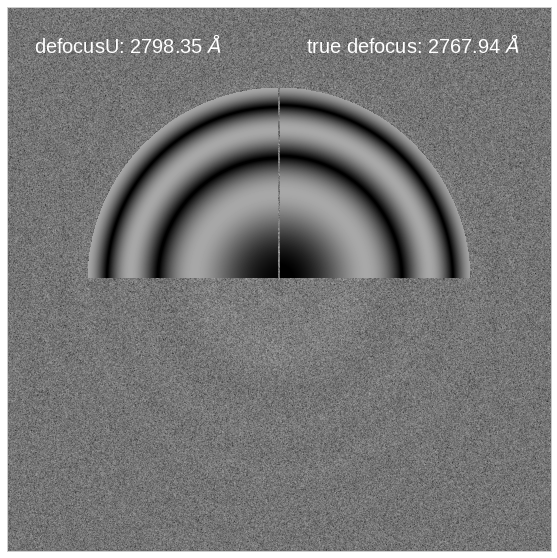

In [5]:
### plot the CTF estimation for a single micrograph
ugraph_index = 3 # which micrograph to plot

fig, ax = plot_CTF(df_ctf, config_dir, ugraph_index)

plotted index 148; micrograph: 000148.mrc


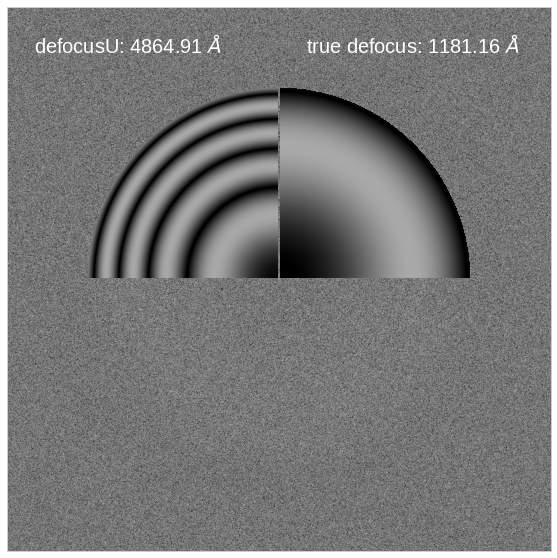

In [6]:
### plot the CTF for the particle with the largest defocus error
delta_defocus = 0
for i, row in df_ctf.iterrows():
    defocusU = row["defocusU"]
    defocus_truth = row["defocus_truth"]
    if np.abs(defocusU - defocus_truth) > delta_defocus:
        delta_defocus = np.abs(defocusU - defocus_truth)
        max_error_index = int(row["ugraph_filename"].strip(".mrc"))

fig, ax = plot_CTF(df_ctf, config_dir, max_error_index)


### Particle picking

In [9]:
### variables
config_dir = "data/6xm5_steered_Roodmus_1/mrc/"
meta_files = [
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J429_passthrough_particles_selected.cs",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J433_passthrough_particles.cs",
]

jobtypes = {
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs": "blob picking",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs": "2D classification",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs": "template picking",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J429_passthrough_particles_selected.cs": "2D classification 2",
    "data/6xm5_steered_Roodmus_1/cryoSPARC/J433_passthrough_particles.cs": "3D classification",   
}

particle_diameter = 100 # approximate particle diameter in Angstroms
verbose = True

In [10]:
### analyse the particle picking
for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis_picking = particle_picking(meta_file, config_dir, particle_diameter, verbose=verbose) # creates the class
    else:
        analysis_picking.compute(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file


loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs...
loaded metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs. determined file type: cs
extracted ugraph paths and positions from metadata file
(358378, 2)
358378
found 358378 particles in 200 micrographs
loaded 200 micrographs from data/6xm5_steered_Roodmus_1/cryoSPARC/J293_picked_particles.cs
dictionaries now contain 358378 particles and 0 true particles


loading ground-truth particle positions: 100%|██████████| 200/200 [00:56<00:00,  3.52it/s]


loaded ground-truth particle positions from config files
[250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 25

calculating true positive picked particles and unpicked truth particles: 100%|██████████| 200/200 [01:28<00:00,  2.25it/s]


0 micrographs were not picked
loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs...
loaded metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs. determined file type: cs
extracted ugraph paths and positions from metadata file
(11634, 2)
11634
found 11634 particles in 200 micrographs
loaded 200 micrographs from data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs
dictionaries now contain 370012 particles and 50000 true particles


loading ground-truth particle positions: 100%|██████████| 200/200 [00:06<00:00, 30.77it/s]


dictionaries now contain 370012 particles and 100000 true particles
calculating true positive picked particles and unpicked truth particles...


calculating true positive picked particles and unpicked truth particles: 100%|██████████| 200/200 [00:18<00:00, 10.77it/s]


0 micrographs were not picked
loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs...
loaded metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs. determined file type: cs
extracted ugraph paths and positions from metadata file
(244327, 2)
244327
found 244327 particles in 200 micrographs
loaded 200 micrographs from data/6xm5_steered_Roodmus_1/cryoSPARC/J298_picked_particles.cs
dictionaries now contain 614339 particles and 100000 true particles


loading ground-truth particle positions: 100%|██████████| 200/200 [00:10<00:00, 18.87it/s]


dictionaries now contain 614339 particles and 150000 true particles
calculating true positive picked particles and unpicked truth particles...


calculating true positive picked particles and unpicked truth particles: 100%|██████████| 200/200 [01:07<00:00,  2.97it/s]


0 micrographs were not picked
loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J429_passthrough_particles_selected.cs...
loaded metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J429_passthrough_particles_selected.cs. determined file type: cs
extracted ugraph paths and positions from metadata file
(16501, 2)
16501
found 16501 particles in 200 micrographs
loaded 200 micrographs from data/6xm5_steered_Roodmus_1/cryoSPARC/J429_passthrough_particles_selected.cs
dictionaries now contain 630840 particles and 150000 true particles


loading ground-truth particle positions: 100%|██████████| 199/199 [00:14<00:00, 13.41it/s]


dictionaries now contain 630840 particles and 199750 true particles
calculating true positive picked particles and unpicked truth particles...


calculating true positive picked particles and unpicked truth particles: 100%|██████████| 200/200 [00:28<00:00,  7.09it/s]


1 micrographs were not picked
loading metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J433_passthrough_particles.cs...
loaded metadata from data/6xm5_steered_Roodmus_1/cryoSPARC/J433_passthrough_particles.cs. determined file type: cs
extracted ugraph paths and positions from metadata file
(9592, 2)
9592
found 9592 particles in 200 micrographs
loaded 200 micrographs from data/6xm5_steered_Roodmus_1/cryoSPARC/J433_passthrough_particles.cs
dictionaries now contain 640432 particles and 199750 true particles


loading ground-truth particle positions: 100%|██████████| 198/198 [00:22<00:00,  8.68it/s]


dictionaries now contain 640432 particles and 249250 true particles
calculating true positive picked particles and unpicked truth particles...


calculating true positive picked particles and unpicked truth particles: 100%|██████████| 200/200 [00:28<00:00,  6.94it/s]

2 micrographs were not picked


In [11]:
df_picked = pd.DataFrame(analysis_picking.results_picking)
df_truth = pd.DataFrame(analysis_picking.results_truth)
df_picked

,metadata_filename,ugraph_filename,position_x,position_y,ugraph_shape,TP,defocus
0,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,2336.000000,885.333374,"[4000, 4000]",False,1544.884766
1,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,3125.333252,2474.666504,"[4000, 4000]",True,1544.884766
2,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,2197.333252,2336.000000,"[4000, 4000]",False,1544.884766
3,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,3680.000000,2634.666748,"[4000, 4000]",False,1544.884766
4,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,480.000000,906.666687,"[4000, 4000]",False,1544.884766
...,...,...,...,...,...,...,...
640427,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,3424.000000,3637.333496,"[4000, 4000]",True,NaN
640428,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,1941.333252,1525.333252,"[4000, 4000]",True,NaN
640429,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,970.666626,426.666687,"[4000, 4000]",True,NaN
640430,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,3093.333252,3317.333252,"[4000, 4000]",True,NaN


plotted index 0; micrograph: 000000.mrc
Using box half width: 16.0 and half height: 16.0
number of boxes: 44


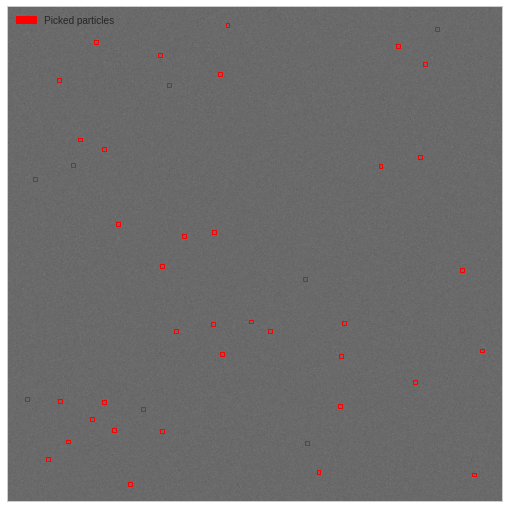

In [12]:
### plot the picked particles
ugraph_index = 0 # which micrograph to plot
metadata_index = 1 # which metadata file to plot

fig, ax = label_micrograph_picked(df_picked.groupby("metadata_filename").get_group(meta_files[metadata_index]), ugraph_index, config_dir, box_width=32, box_height=32, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)


plotted index 3; micrograph: 000003.mrc
Using box half width: 16.0 and half height: 16.0
number of boxes: 250


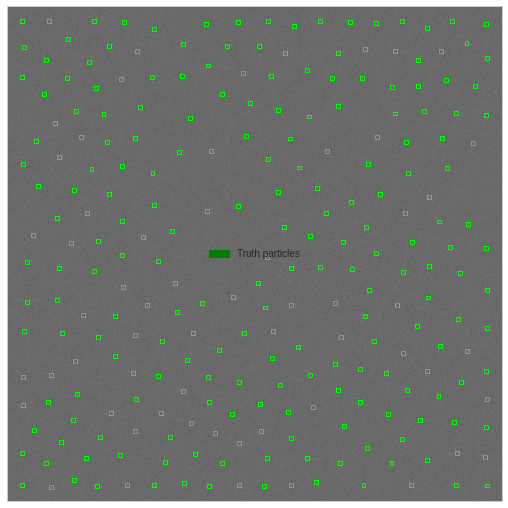

In [13]:
### plot the truth particles
ugraph_index = 3 # which micrograph to plot
metadata_index = 0 # which metadata file to plot

fig, ax = label_micrograph_truth(df_truth.groupby("metadata_filename").get_group(meta_files[metadata_index]), ugraph_index, config_dir, box_width=32, box_height=32, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)


plotted index 3; micrograph: 000003.mrc
Using box half width: 24.0 and half height: 24.0
number of boxes: 1209
Using box half width: 24.0 and half height: 24.0
number of boxes: 250


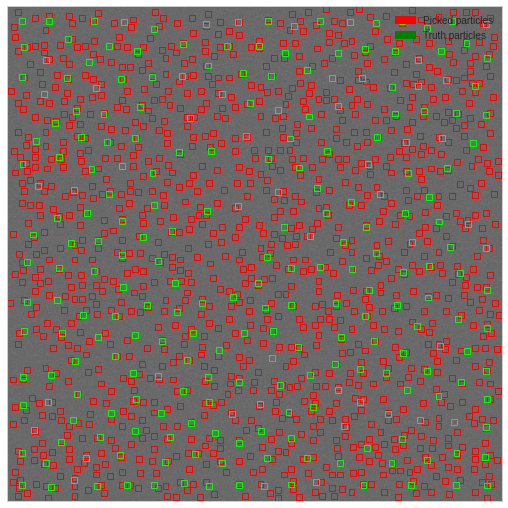

In [14]:
### plot the truth and picked particles
ugraph_index = 3 # which micrograph to plot
metadata_index = 2 # which metadata file to plot

fig, ax = label_micrograph_truth_and_picked(df_picked.groupby("metadata_filename").get_group(meta_files[metadata_index]),
                                             df_truth.groupby("metadata_filename").get_group(meta_files[metadata_index]),
                                               ugraph_index, config_dir, box_width=48, box_height=48, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)


In [15]:
### compute precision and recall
df_precision = analysis_picking.compute_precision(df_picked, df_truth)
df_precision

metadata_filename  \
metadata_filename                                  ugraph_filename                                                      
data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pick... 000000.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...   
                                                   000001.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...   
                                                   000002.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...   
                                                   000003.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...   
                                                   000004.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...   
...                                                                                                               ...   
data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pass... 000195.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...   
                                                   000196.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...   
                                                   000197.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...   
                                                   000198.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...   
                                                   000199.mrc       data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...   

                                                                   ugraph_filename  \
metadata_filename                                  ugraph_filename                   
data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pick... 000000.mrc           000000.mrc   
                                                   000001.mrc           000001.mrc   
                                                   000002.mrc           000002.mrc   
                                                   000003.mrc           000003.mrc   
                                                   000004.mrc           000004.mrc   
...                                                                            ...   
data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pass... 000195.mrc           000195.mrc   
                                                   000196.mrc           000196.mrc   
                                                   000197.mrc           000197.mrc   
                                                   000198.mrc           000198.mrc   
                                                   000199.mrc           000199.mrc   

                                                                    precision  \
metadata_filename                                  ugraph_filename              
data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pick... 000000.mrc        0.137950   
                                                   000001.mrc        0.139212   
                                                   000002.mrc        0.145042   
                                                   000003.mrc        0.145404   
                                                   000004.mrc        0.133371   
...                                                                       ...   
data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pass... 000195.mrc        1.000000   
                                                   000196.mrc        0.805556   
                                                   000197.mrc        0.750000   
                                                   000198.mrc        0.958333   
                                                   000199.mrc        1.000000   

                                                                      recall  \
metadata_filename                                  ugraph_filename             
data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pick... 000000.mrc       0.859649   
                                                   000001.mrc       0.874564   
                                 

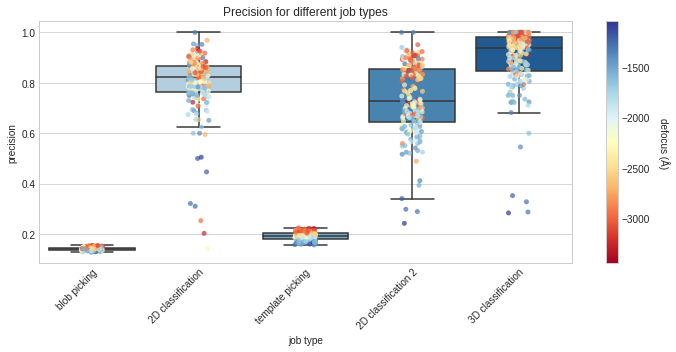

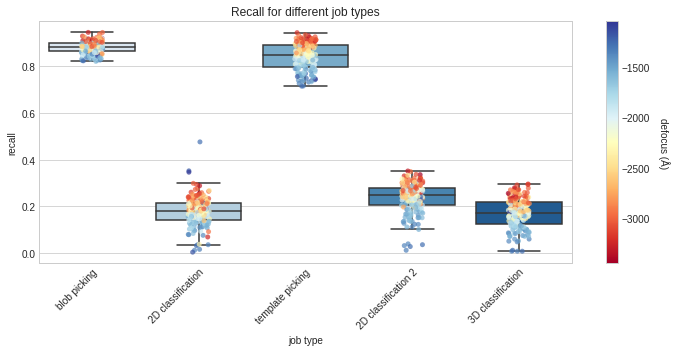

In [20]:
### plot boxplot for precision and recall
fig, ax = plot_precision(df_precision, jobtypes)
fig, ax = plot_recall(df_precision, jobtypes)


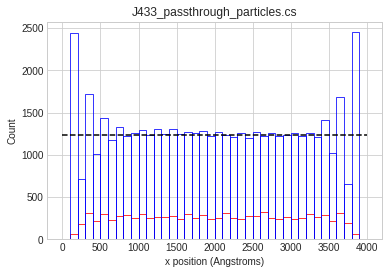

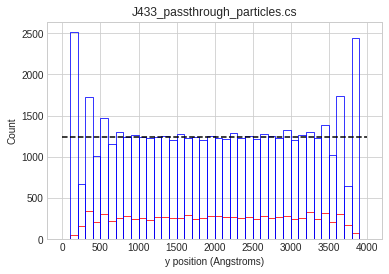

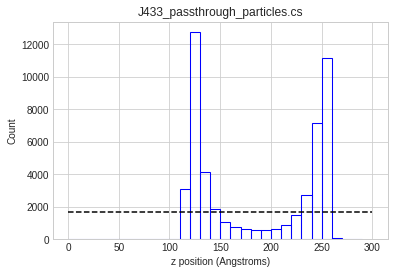

In [21]:
### plot the distribution of the particles in the ugraphs in x, y, and z directions
metadata_index = 4 # which metadata file to plot
bin_width = [100, 100, 10] # bin width for x, y, z
axis = ["x", "y", "z"]

metadata_filename = meta_files[metadata_index]
for a, bnwdth in zip(axis, bin_width):
    fig, ax = plot_boundary_investigation(df_truth, df_picked, metadata_filename, bnwdth, axis=a)

In [22]:
df_overlap = analysis_picking.compute_overlap(df_picked, df_truth, verbose=verbose)
df_overlap

computing overlap: 100%|██████████| 997/997 [00:04<00:00, 221.98it/s]


,metadata_filename,ugraph_filename,defocus,radius,neighbours_truth,neighbours_picked
0,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,-1459.348516,5.0,0.0,2.0
1,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,-1459.348516,10.0,0.0,5.0
2,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,-1459.348516,15.0,0.0,11.5
3,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,-1459.348516,20.0,0.0,23.5
4,data/6xm5_steered_Roodmus_1/cryoSPARC/J293_pic...,000000.mrc,-1459.348516,25.0,0.0,41.5
...,...,...,...,...,...,...
39875,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,-3073.016084,180.0,0.0,34.0
39876,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,-3073.016084,185.0,0.0,34.5
39877,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,-3073.016084,190.0,0.0,35.5
39878,data/6xm5_steered_Roodmus_1/cryoSPARC/J433_pas...,000199.mrc,-3073.016084,195.0,0.0,35.5


plotting overlap for data/6xm5_steered_Roodmus_1/cryoSPARC/J297_passthrough_particles_selected.cs


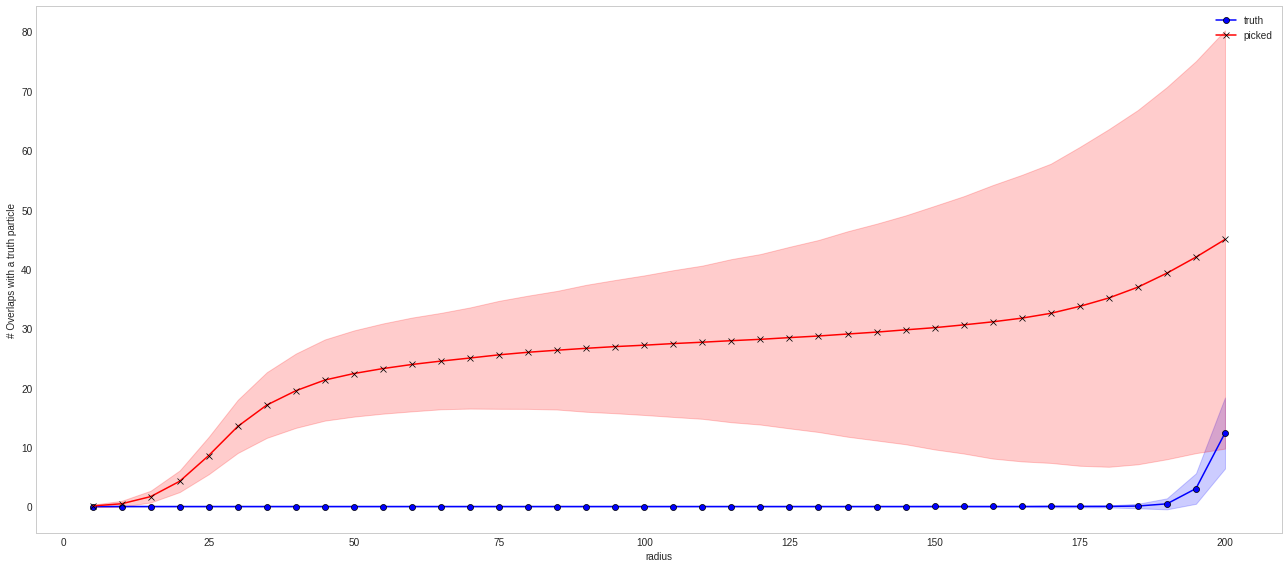

In [24]:
### plot the overlap between the picked and truth particles
metadata_index = 1 # which metadata file to plot. If None, all metadata files are plotted

metadata_filename = meta_files[metadata_index]
fig, ax = plot_overlap_investigation(df_overlap, metadata_filename, jobtypes=jobtypes)
